Data location: https://kingcounty.gov/en/dept/metro/rider-tools/mobile-and-web-apps#toc-developer-resources

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import seaborn as sns
import plotly as py
import dill
import os

from mypy.checker import and_conditional_maps

import GTFS_Functions as my

from numpy.lib.recfunctions import drop_fields

In [4]:
#solve the 'fuzzy text' issue by increasing the DPI with a whole format change (from Matplotlib)
%config InlineBackend.figure_format='retina'

In [152]:
#Import all dataframe pickles in pickle folder
pickle_in = os.listdir("./pickles")

for df in [x[0:-4] for x in pickle_in]:
    exec(f"{df} = pd.read_pickle('./pickles/{df}.pkl')")

pickle_in

['agency.pkl',
 'calendar.pkl',
 'calendar_dates.pkl',
 'calendar_full.pkl',
 'calendar_week.pkl',
 'calendar_week_mean.pkl',
 'fare_attributes.pkl',
 'fare_rules.pkl',
 'routes.pkl',
 'shapes.pkl',
 'stops.pkl',
 'stop_freq.pkl',
 'stop_times.pkl',
 'trips.pkl']

In [155]:
stop_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069677 entries, 0 to 1069676
Data columns (total 32 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   trip_id              1069677 non-null  int64          
 1   arrival_time         1069677 non-null  timedelta64[ns]
 2   departure_time       1069677 non-null  timedelta64[ns]
 3   stop_id              1069677 non-null  int64          
 4   stop_sequence        1069677 non-null  int64          
 5   stop_headsign        207924 non-null   object         
 6   pickup_type          1069677 non-null  int64          
 7   drop_off_type        1069677 non-null  int64          
 8   shape_dist_traveled  1069677 non-null  float64        
 9   timepoint            1069677 non-null  int64          
 10  route_id             1069677 non-null  int64          
 11  service_id           1069677 non-null  int64          
 12  trip_headsign        1069677 non-null  obj

### Treatment
#### convert numbers to datetime

### Combine both Calendar dataframes

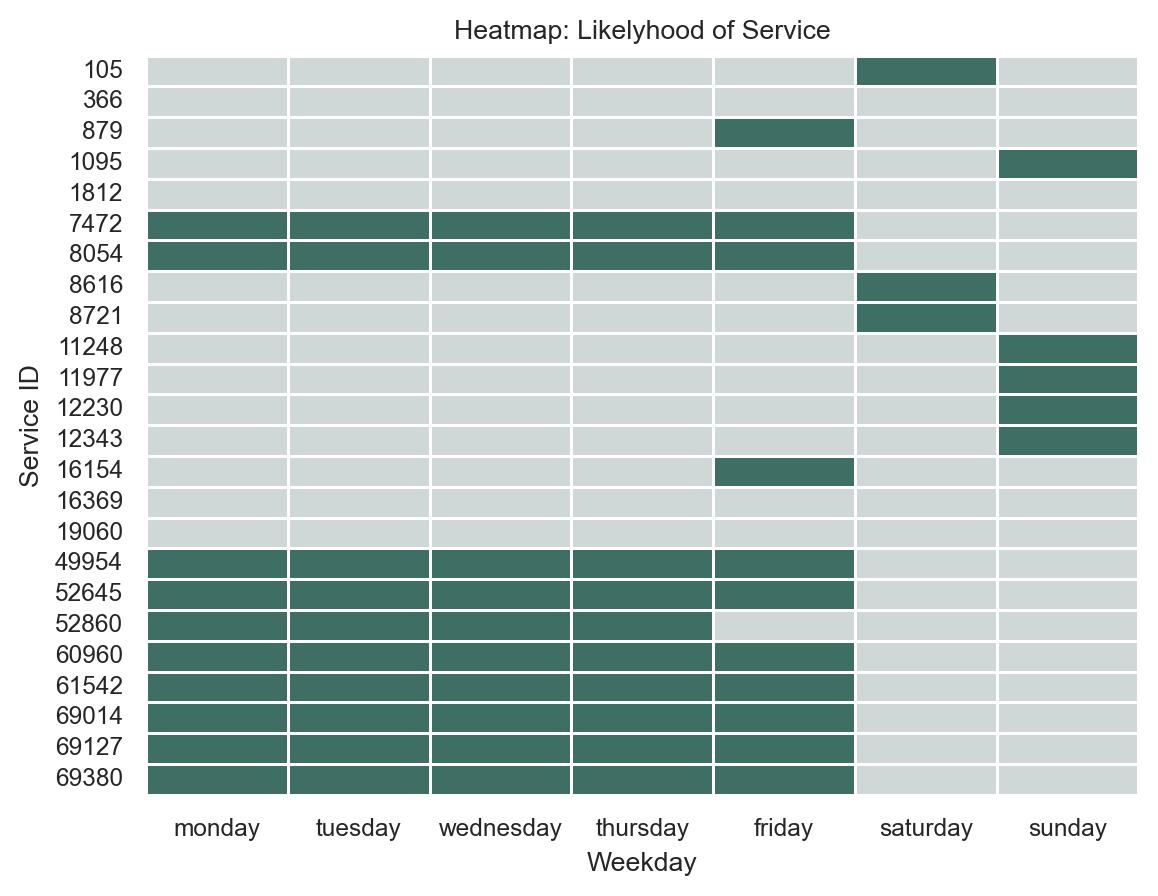

In [39]:
sns.set_context('paper')
sns.color_palette('blend:#3e6e64,#c3d4d0', as_cmap = True)
ax = (sns.heatmap(calendar_week.set_index("service_id").iloc[:,:-2], 
            yticklabels = True, 
            cbar = False, 
            cmap = sns.color_palette('blend:#cfd8d6,#3e6e64', as_cmap = True), 
            linewidth = 0.5
           )
    )
ax.set(xlabel = "Weekday",
      ylabel = "Service ID",
      title = "Heatmap: Likelyhood of Service"
     )
plt.show()

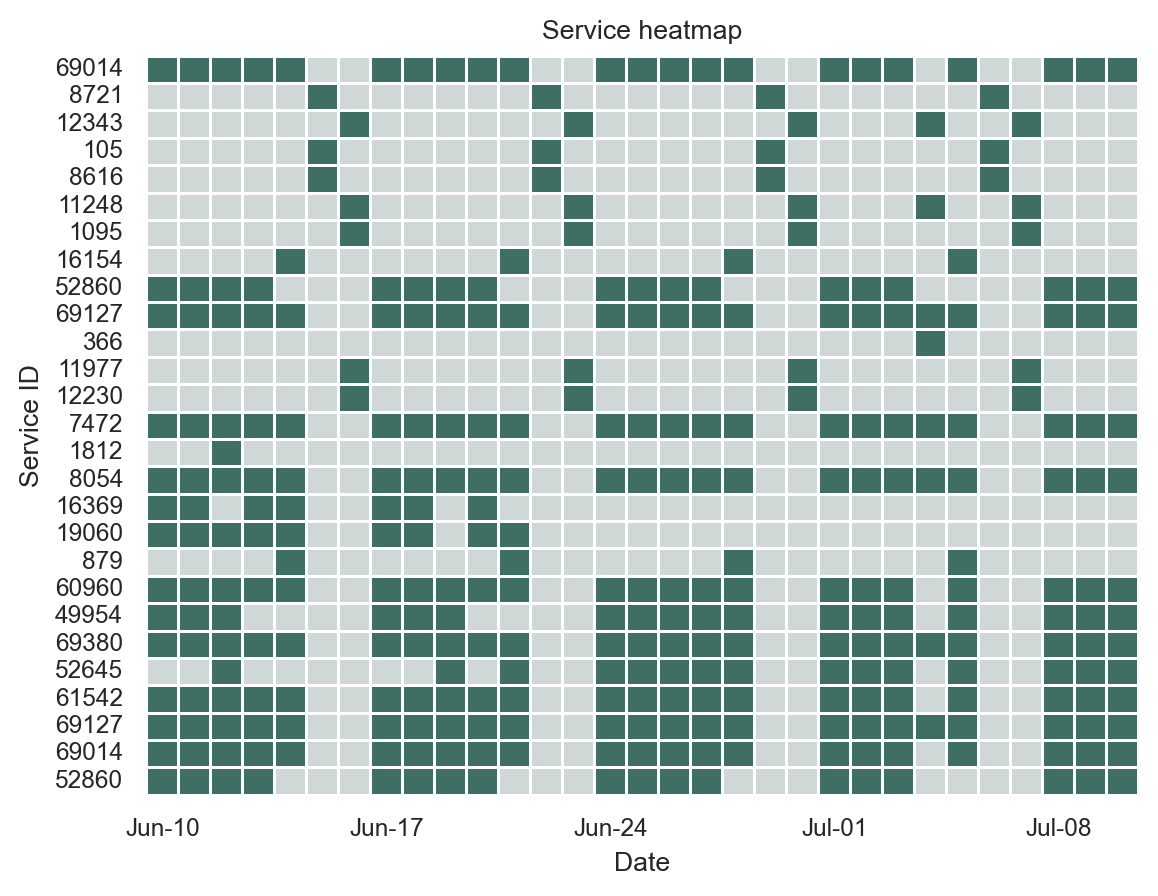

In [40]:
# Order service ids by how many trips they are assigned to, in descending order.
# service ids with no trips are appended to the end
cal_full_alt = calendar_full.set_index("service_id").copy()

x = pd.Index(set(cal_full_alt.index).difference(set(trips.index)))
x = trips.value_counts("service_id").index.append(x)
cal_full_alt_graph = cal_full_alt.reindex(x, copy = True)

# change timestamps in column axis to strings for visualization
cal_full_alt_graph.columns = [y.strftime("%b-%d") for y in cal_full_alt.columns]



sns.set_context('paper')
sns.color_palette('blend:#3e6e64,#c3d4d0', as_cmap = True)
ax = (sns.heatmap(cal_full_alt_graph.iloc[:,0:31], 
            yticklabels = True, 
            cbar = False, 
            cmap = sns.color_palette('blend:#cfd8d6,#3e6e64', as_cmap = True), 
            linewidth = 0.5
           )
    )
ax.set(xlabel = "Date",
      ylabel = "Service ID",
      title = "Service heatmap"
     )

#ax.xaxis.set_major_formatter(mpldates.DateFormatter("%d-%b")) doesnt work yet, moving on
xtix = ax.get_xticks()
ax.set_xticks(xtix[::7])
ax.set_xticklabels(cal_full_alt_graph.iloc[:,0:31].columns[::7])
ax.tick_params(axis = 'x', rotation = 0)
plt.show()

## Create Stop Frequency Chart tool

In [169]:
stop_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069677 entries, 0 to 1069676
Data columns (total 32 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   trip_id              1069677 non-null  int64          
 1   arrival_time         1069677 non-null  timedelta64[ns]
 2   departure_time       1069677 non-null  timedelta64[ns]
 3   stop_id              1069677 non-null  int64          
 4   stop_sequence        1069677 non-null  int64          
 5   stop_headsign        207924 non-null   object         
 6   pickup_type          1069677 non-null  int64          
 7   drop_off_type        1069677 non-null  int64          
 8   shape_dist_traveled  1069677 non-null  float64        
 9   timepoint            1069677 non-null  int64          
 10  route_id             1069677 non-null  int64          
 11  service_id           1069677 non-null  int64          
 12  trip_headsign        1069677 non-null  obj

In [177]:
tg = stop_freq.loc[((stop_freq['stop_id'] == 8402) & \
               (stop_freq['route_id'] ==  100275) & \
               (stop_freq['direction_id'] == 1) & \
               (stop_freq['monday'] == 1)), ['arrival_time','time_f_monday']]

tg["delta_val"] = tg["time_f_monday"].map(lambda x: x.seconds/60)
tg["time_val"] = tg["arrival_time"].map(lambda x: x.seconds/3600)
tg

,arrival_time,time_f_monday,delta_val,time_val
305983,0 days 07:22:00,0 days 00:15:00,15.0,442.0
306054,0 days 09:22:00,0 days 00:12:00,12.0,562.0
306230,1 days 00:57:00,0 days 00:30:00,30.0,57.0
306266,0 days 09:10:00,0 days 00:11:00,11.0,550.0
306442,0 days 05:32:00,0 days 04:35:00,275.0,332.0
...,...,...,...,...
518249,0 days 22:32:00,0 days 00:20:00,20.0,1352.0
518285,0 days 23:02:00,0 days 00:30:00,30.0,1382.0
518321,0 days 23:32:00,0 days 00:30:00,30.0,1412.0
518357,0 days 23:59:00,0 days 00:27:00,27.0,1439.0


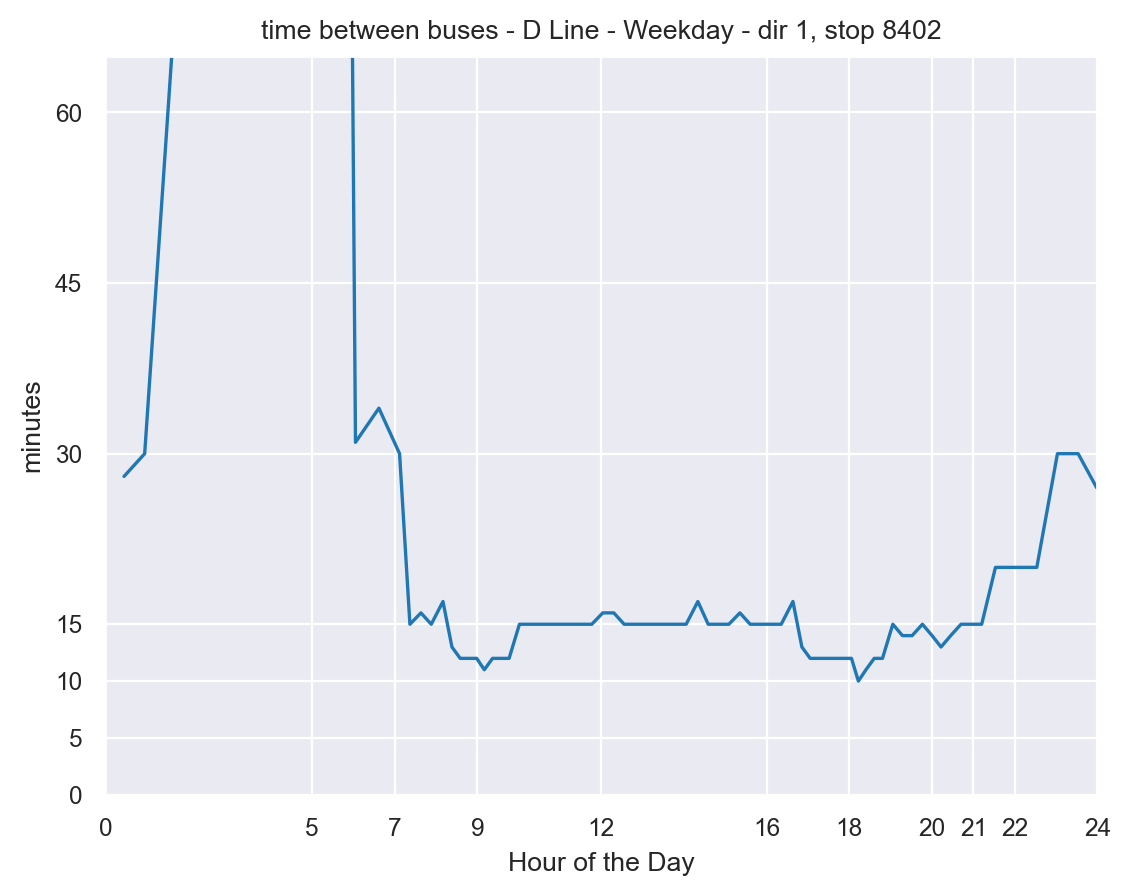

In [181]:
# how to apply filters to lineplot
# collapse weeks down into one column (for use)


sns.set_style("darkgrid")
ax =(sns.lineplot(data = tg,
                  x = 'time_val',
                  y = 'delta_val'
                 )
    )

ax.set(xlabel = "Hour of the Day",
      ylabel = "minutes",
      title = "time between buses - D Line - Weekday - dir 1, stop 8402"
     )

#xtix = ax.get_xticks()
ax.set_yticks([0,5,10,15,30,45,60])
ax.set_ylim(0,65)
ax.set_xticks([0,5,7,9,12,16,18,20,21,22,24])
ax.set_xlim(0,24)
#ax.set_xticklabels(cal_full_alt_graph.iloc[:,0:31].columns[::7])
#ax.tick_params(axis = 'x', rotation = 0)

plt.show()

In [41]:
# I have a map of the average service_ids for any given weekday (or specific day)
# For any given route and day, find all the trips.
# next lets get the start time for all of them

In [42]:

#attach routes to trips on route_id for route_names

#combine stop_times to trips on trip_id tring to pull the first arrival_time


In [43]:
def trips_merged(trips, stop_times, routes, calendar_week):
    """
    
    """
    #pull stop times
    stop_times["index_og"] = stop_times.index
    stop_times_index = stop_times.groupby(["trip_id"])[["arrival_time","index_og"]].min("arrival_time")["index_og"]
    trip_times = stop_times.loc[stop_times_index,["trip_id","arrival_time"]]

    #pull route names
    trip_routes = routes.loc[:,["route_id","route_short_name","route_desc"]]
    
    #pull service_weekdays
    # just drop it in
    
    trips_alt = pd.merge(left = trips, right = trip_times, how = "inner", on = "trip_id")
    
    trips_alt = pd.merge(left = trips_alt, right = trip_routes, how = "inner", on = "route_id")
    
    trips_alt = pd.merge(left = trips_alt, right = calendar_week, how = "inner", on = "service_id")

    return trips_alt
    
def routes_on_a_day(trips, weekday, route,direction):
    return trips.loc[((trips["route_short_name"] == route) & 
                      (trips[weekday] == 1) & \
                      (trips["direction_id"] == direction)),
                     :].sort_values("arrival_time")
    
def stop_time_to_datetime(value):
    time = value
    hour = int(time[0:2])
    if hour > 23:
        day = "1970-01-02"
        hour = hour - 24
        time = str(hour) + time[2:-1]
    else:
        day = "1970-01-01"
    return pd.to_datetime((day + " " + time))

def create_time_delta(df, time_col, delta_col):
    """
    outputs the same df, with a new column, delt_col
    
    the timedelta for each point is the time elapsed BEFORE the point.
    delta = Tn - T(n-1)
    
    df: dataframe with the datetime to build from
        dataframe the delta time will be added to
        
    time_col: name of the column with datetime information.
              must be in timestamp format
              
    delta_col: the name of the new column
    """
    # Create a column of the differences
    df[delta_col] = df[time_col].diff()
    
    # create a timedelta object equal to one day 
    one_day = pd.to_timedelta(1, unit='d')
    
    # calculate the time differential between the last and the first value.
    df.loc[df.index[0],delta_col] = \
                                    df[time_col].iloc[0] - \
                                    (df[time_col].iloc[-1] - one_day)
    
    return df

In [160]:
import GTFS_Functions as my

route_choice = "D Line"
weekday_choice = "friday"
direction_choice = 1

# merge data desired
trips_alt = trips_merged(trips, stop_times, routes, calendar_week)
# filter to the desired information
route_day = routes_on_a_day(trips_alt, weekday_choice, route_choice, direction_choice)
# filter to desired columns
route_day = route_day.loc[:,["service_id","arrival_time","route_short_name"]]
# Convert 'arrival time' to datetime
route_day['arrival_time'] = route_day['arrival_time'].map(stop_time_to_datetime)
# create time_delta: difference between arrival times
route_day = my.create_time_delta(route_day, "arrival_time", "time_delta")
route_day.head()

,time_delta
13278,0 days 01:05:00
1583,0 days 00:16:00
1585,0 days 00:12:00
13279,0 days 00:10:00
1589,0 days 00:08:00


In [161]:
route_day.groupby(['service_id']).nunique()

KeyError: 'service_id'

In [162]:
# Convert timestamp and deltatime objects to numbers.  Graphing cannot understand datetime objects.
route_day["delta_val"] = route_day["time_delta"].map(lambda x: x.seconds/60)
route_day["time_val"] = route_day["arrival_time"].map(lambda x: x.hour + x.minute/60)

sns.set_style("darkgrid")
ax =(sns.lineplot(data = route_day,
                  x = 'time_val',
                  y = 'delta_val'
                 )
    )

ax.set(xlabel = "Hour of the Day",
      ylabel = "minutes",
      title = "time between buses - D Line - Weekday - dir 1"
     )

#xtix = ax.get_xticks()
ax.set_yticks([0,5,10,15,30,45,60])
ax.set_ylim(0,65)
ax.set_xticks([0,5,7,9,12,16,18,20,21,22,24])
ax.set_xlim(0,24)
#ax.set_xticklabels(cal_full_alt_graph.iloc[:,0:31].columns[::7])
#ax.tick_params(axis = 'x', rotation = 0)

plt.show()

KeyError: 'arrival_time'